In [26]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [27]:
import pandas as pd


df = pd.read_csv('train.csv')


diagnosis_dict_binary = {0: 'No_DR', 1: 'DR', 2: 'DR', 3: 'DR', 4: 'DR'}
diagnosis_dict = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


df['binary_type'] = df['diagnosis'].apply(lambda x: diagnosis_dict_binary.get(x))
df['type'] = df['diagnosis'].apply(lambda x: diagnosis_dict.get(x))


print(df.head())


        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR


<Axes: >

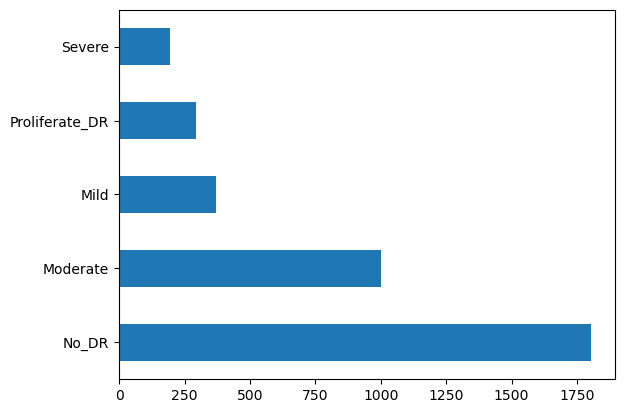

In [28]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

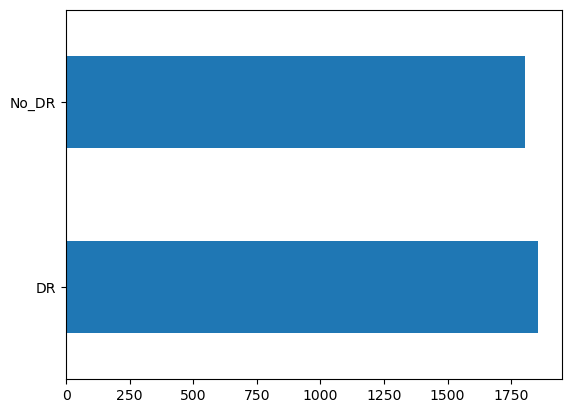

In [29]:
df['binary_type'].value_counts().plot(kind='barh')

In [30]:
from sklearn.model_selection import train_test_split

# Split into stratified train, val, and test sets
train, test_val = train_test_split(df, test_size=0.15, stratify=df['type'])
test, val = train_test_split(test_val, test_size=0.15 / (1 - 0.15), stratify=test_val['type'])

# Display the class distribution in each set
print("Train Set:")
print(train['type'].value_counts(), '\n')

print("Test Set:")
print(test['type'].value_counts(), '\n')

print("Validation Set:")
print(val['type'].value_counts(), '\n')


Train Set:
No_DR             1534
Moderate           849
Mild               314
Proliferate_DR     251
Severe             164
Name: type, dtype: int64 

Test Set:
No_DR             223
Moderate          123
Mild               46
Proliferate_DR     36
Severe             24
Name: type, dtype: int64 

Validation Set:
No_DR             48
Moderate          27
Mild              10
Proliferate_DR     8
Severe             5
Name: type, dtype: int64 



In [31]:
# Create working directories for train/val/test
base_dir = '/path/to/your/dataset'  # Replace with your desired path

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Remove existing directories if they exist
for directory in [base_dir, train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        shutil.rmtree(directory)

# Create necessary directories
for directory in [base_dir, train_dir, val_dir, test_dir]:
    os.makedirs(directory)


In [32]:

# Define source and destination directories
src_dir = r'Downloads/gaussian_filtered_images/gaussian_filtered_images'
base_dir = '/path/to/your/dataset'  # Replace with your desired path

# Loop through the data and copy images to respective working directories
for index, row in df.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    
    # Determine the destination directory based on the split (train, val, test)
    if index in train.index:
        dst_dir = os.path.join(base_dir, 'train', binary_diagnosis)
    elif index in val.index:
        dst_dir = os.path.join(base_dir, 'val', binary_diagnosis)
    else:
        dst_dir = os.path.join(base_dir, 'test', binary_diagnosis)
    
    # Create the destination directory if it doesn't exist
    os.makedirs(dst_dir, exist_ok=True)
    
    # Construct source and destination file paths
    src_file = os.path.join(src_dir, diagnosis, id_code)
    dst_file = os.path.join(dst_dir, id_code)
    
    # Copy the file
    shutil.copy(src_file, dst_file)


In [33]:
from keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = '/path/to/your/dataset'  # Replace with your dataset path
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

# Set up ImageDataGenerator for train/val/test
datagen = ImageDataGenerator(rescale=1./255)

train_batches = datagen.flow_from_directory(train_path, target_size=(224, 224), shuffle=True)
val_batches = datagen.flow_from_directory(val_path, target_size=(224, 224), shuffle=True)
test_batches = datagen.flow_from_directory(test_path, target_size=(224, 224), shuffle=False)


Found 3112 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 452 images belonging to 2 classes.


In [34]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), padding="valid", input_shape=(224, 224, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])


history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
98/98 [==============================] - 58s 566ms/step - loss: 0.2548 - acc: 0.9116 - val_loss: 0.9531 - val_acc: 0.5102
Epoch 2/50
98/98 [==============================] - 43s 441ms/step - loss: 0.1676 - acc: 0.9457 - val_loss: 1.0088 - val_acc: 0.5102
Epoch 3/50
98/98 [==============================] - 46s 469ms/step - loss: 0.1192 - acc: 0.9573 - val_loss: 0.7751 - val_acc: 0.5306
Epoch 4/50
98/98 [==============================] - 45s 460ms/step - loss: 0.0942 - acc: 0.9640 - val_loss: 0.4510 - val_acc: 0.7551
Epoch 5/50
98/98 [==============================] - 45s 457ms/step - loss: 0.0661 - acc: 0.9810 - val_loss: 0.2622 - val_acc: 0.8980
Epoch 6/50
98/98 [==============================] - 45s 459ms/step - loss: 0.0530 - acc: 0.9817 - val_loss: 0.2788 - val_acc: 0.9184
Epoch 7/50
98/98 [==============================] - 45s 456ms/step - loss: 0.0348 - acc: 0.9910 - val_loss: 0.2502 - val_acc: 0.9388
Epoch 8/50
98/98 [==============================] - 45s 459ms/step - 

In [40]:
model.save('CNN.Finalmodel')

INFO:tensorflow:Assets written to: CNN.Finalmodel\assets


INFO:tensorflow:Assets written to: CNN.Finalmodel\assets


In [41]:
loss, acc = model.evaluate(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

15/15 [==============================] - 2s 152ms/step - loss: 0.5845 - acc: 0.9314
Accuracy:  0.9314159154891968


# Diabet Retinopathy Detection Section

In [42]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNN.Finalmodel")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')
    

1/1 [==============================] - 0s 125ms/step
DR


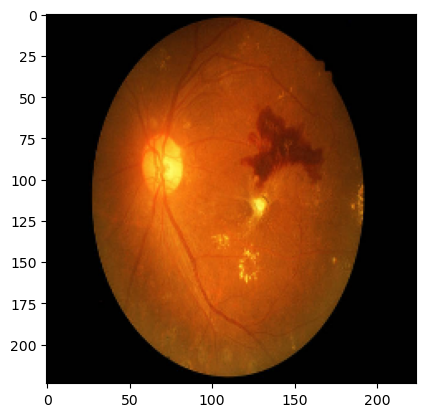

In [44]:
predict_class('Downloads/gaussian_filtered_images/istockphoto-530338547-612x612.jpg')